# Notebook preparation

## Install dependencies

In [331]:
%%capture
%pip install numpy pandas tensorflow tensorflow_datasets matplotlib seaborn

## Import code dependencies

In [332]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.data import Dataset
import seaborn as sns
print('Packages imported successfully');

Packages imported successfully


In [333]:
def print_versions():
  print('tensorflow: ', tf.__version__)
  print('tensorflow_datasets: ', tfds.__version__)

print_versions()

tensorflow:  2.17.0
tensorflow_datasets:  4.9.6


# Load and examine dataset 
Download [The Malaria dataset](https://www.tensorflow.org/datasets/catalog/malaria)

In [334]:
ds, info = tfds.load('malaria', split='train', shuffle_files=False, with_info=True)

## Verify that the dataset conforms to documentation
The metadata _features_ and _splits_ are according to documenation expected to be similar to
```
info.features= FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
info.splits= {'train': <SplitInfo num_examples=27558, num_shards=4>}
```
This fits our expectation that the data contains a training set consisting of nand valiumerically (0, 1) labelled images.
The dataset has only a single split, so we have to devise a strategy for spliiting into train, test and validation.

In [335]:
print('info.features=', info.features)
print('info.splits=', info.splits)

info.features= FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
info.splits= {'train': <SplitInfo num_examples=27558, num_shards=4>}


## Understanding the dataset

### Preview a sample from the dataset

2024-11-07 11:55:13.316290: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


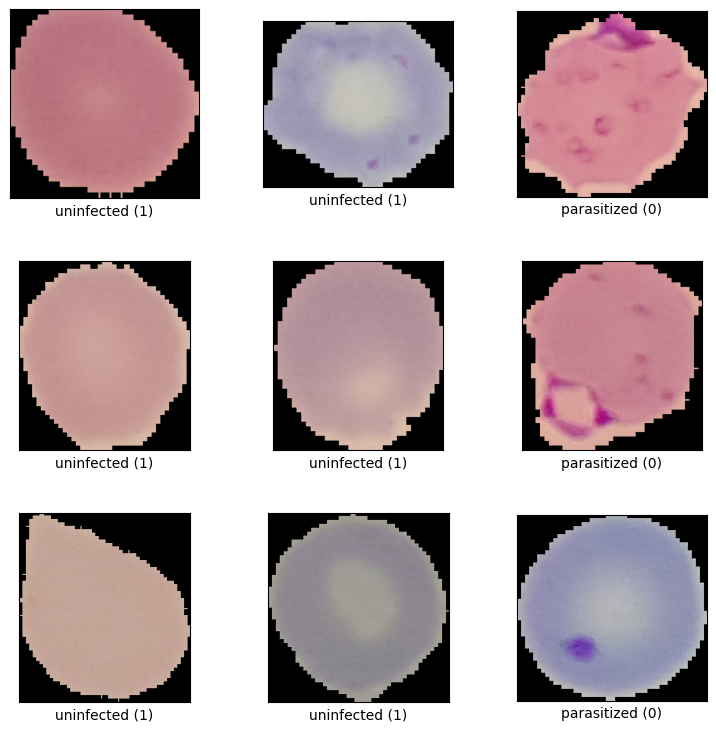

In [336]:
tfds.show_examples(ds, info, rows=3, cols=3);

From the above samples we can conclude that
- images are color encoded
- base colors differ
- the images seems to be carefully cropped
- the images are pure and free from artifacts such as qr-codes, watermarks or other annotations
- the images varies in size
- not all images are quadratic

### Statistical analysis

#### The dataset is balanced

The labels are 0 or 1, corresponding to _parazitized_ and _unifected_.

In [337]:
info.features['label'].names

['parasitized', 'uninfected']

Furthermore, the distribution of the images over the label is well balanced.

<Axes: title={'center': 'Image count per label'}, xlabel='label', ylabel='image count'>

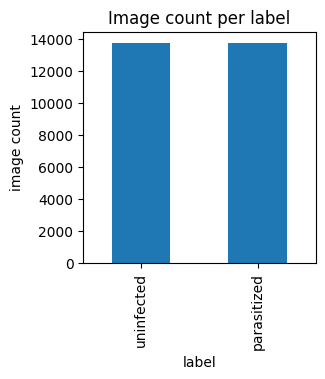

In [338]:
def get_label_name(label: int) -> str:
    return info.features['label'].names[label]

(DataFrame({
    'label': [get_label_name(d['label'].numpy()) for d in ds]
    })['label']
    .value_counts()
    .plot.bar(title='Image count per label', figsize=(3,3), ylabel='image count', xlabel='label'))

#### Investigation of image dimensions

The images are reperesented by [tensorflow tensors](https://www.tensorflow.org/api_docs/python/tf/Tensor). Individual color channels (RGB) are encoded as unsigned bytes.

In [339]:
from scipy import stats
for image in ds.take(1):
  print('Image color channel range: ', stats.describe((image['image'].numpy().flatten())).minmax)
  print('Image encoding: ', image['image'])


Image color channel range:  (0, 218)
Image encoding:  tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(103, 103, 3), dtype=uint8)


Extract width, height, aspect ratio and size for each image and print a basic statistical analysis.

                size         width        height  aspect ratio
count   27558.000000  27558.000000  27558.000000  27558.000000
mean    53507.269105    132.983453    132.487154      1.013867
std     14902.714162     20.619650     20.015949      0.150037
min      6600.000000     40.000000     46.000000      0.385366
25%     44202.000000    121.000000    121.000000      0.925000
50%     51870.000000    130.000000    130.000000      1.000000
75%     60465.000000    145.000000    142.000000      1.086331
max    371280.000000    385.000000    394.000000      2.184211
[Text(0.5, 1.0, 'Image width and height')]


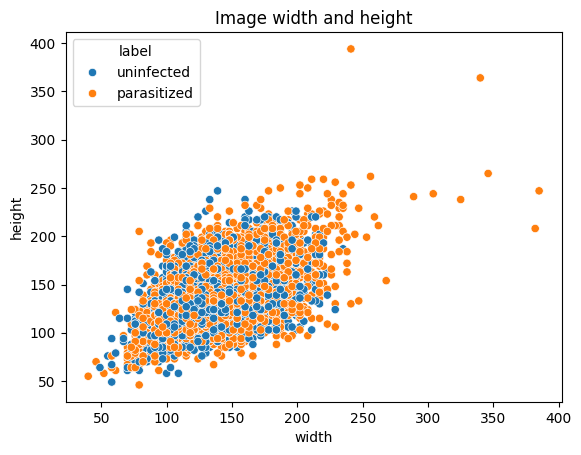

In [340]:
def get_image_characteristics(ds: tf.data.Dataset, sample_size: int) -> DataFrame:
  labels = [get_label_name(d['label'].numpy()) for d in ds.take(sample_size)]
  image_size_width_height = [(
    len(d['image'].numpy().flatten()),
    d['image'].shape[0],
    d['image'].shape[1],
  ) for d in ds.take(sample_size)]

  return DataFrame({
    'label': labels,
    'size': [t[0] for t in image_size_width_height],
    'width': [t[1] for t in image_size_width_height],
    'height': [t[2] for t in image_size_width_height],
    'aspect ratio': [t[1]/t[2] for t in image_size_width_height],
  })

print(get_image_characteristics(ds,-1).describe())
print(sns.scatterplot(get_image_characteristics(ds, -1), x='width', y='height', hue='label').set(title='Image width and height'))

We can conclude that
- there is a big span in size
- there is also some variation in dimensions and geometry
- although some parazitized images with witdh > 250 and height > 250 could be considered outlayers, we do not exlude them sinse they dont show any more variation regarding aspect ratio that imges in the main cluster.

To avoid overtraining due to external image characteristics, its wise to normalize with regards to size. This is probably best achieved by scaling images to a sensible size such as (121,121) which is smaller than (roughly) 75% of all images.

array([<Axes: >], dtype=object)

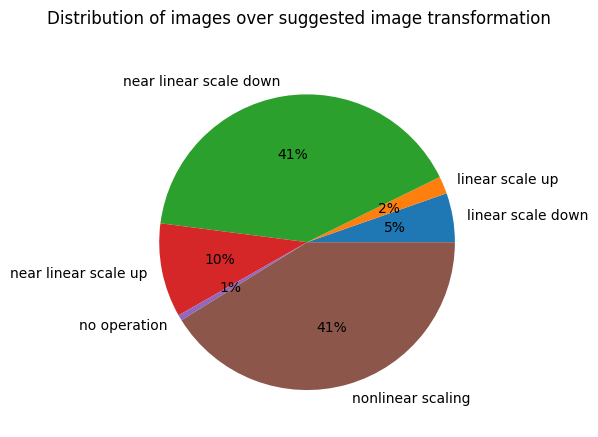

In [341]:
def get_image_characteristics_with_suggested_transform(ds: tf.data.Dataset, sample_size: int, d: int) -> DataFrame:
    def get_operation(actualw: int, actualh: int):
        if actualw/actualh == 1.0:
            return 'no operation' if actualw == d else 'linear scale up' if actualh < d else 'linear scale down'
        if abs(actualw/actualh - 1.0) < 0.1:
            return 'near linear scale up' if actualh < d else 'near linear scale down'
        return 'nonlinear scaling'

    df = get_image_characteristics(ds, sample_size)
    df['image transform'] = df.apply(lambda row: get_operation(row['width'], row['height']), axis=1)
    return df

(get_image_characteristics_with_suggested_transform(ds,-1, 121)
    .groupby('image transform')['image transform'].count()
    .plot.pie(x='image transform', subplots=True, autopct='%.0f%%', title='Distribution of images over suggested image transformation', xlabel='', ylabel=''))


- _no operation_ covers images that already has the dimension (121,121)
- _linear scale up/down_ covers square images
- _near linear scale up/down_ covers images whith aspect ratio between 0.9 and 1.1 (i.e. almost square)
- _nonlinear scaling_ covers standing or lying rectangles that doesnt fit our criteria of (near) squareness

For (training) performance reasons we also want to convert images to grayscale.
- We hypothesise that color has no impact in clinical evaluation, only contrast
- Converting to grayscale can be seen as a way of normalizing and narrowing the image feature, and will probably reduce model training time

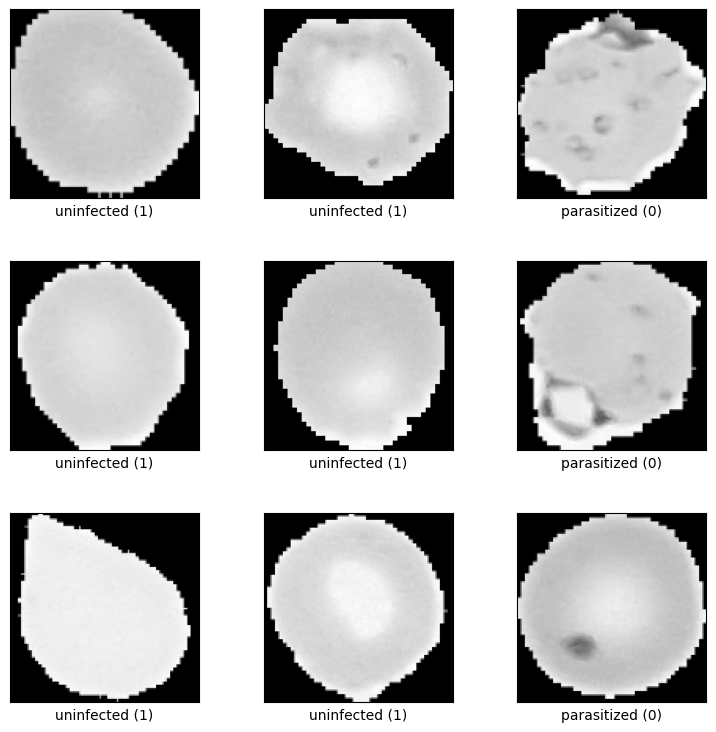

In [342]:
def convert_color_dataset_to_grayscale(ds: Dataset):
    def convert(d):
        image = d['image']
        label = d['label']
        return {
            'image': tf.image.rgb_to_grayscale(tf.image.resize_with_pad(image, 121, 121)),
            'label': label
        }
    return list(map(convert, iter(ds)))

(tfds.show_examples(
    convert_color_dataset_to_grayscale(ds.take(18)),
    info,
    rows=3,
    cols=3));

# Model training and evaluation

To have a clean slate, we reset and (re) import dependencies.

In [343]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import json
import numpy as np
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, Input, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint, TensorBoard
from tensorflow.keras.applications import VGG16
from tensorflow.data import Dataset
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.math import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print('Packages imported successfully');


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Packages imported successfully


We convert and partition the dataset into __ds_train__, __ds_test__ and __ds_validate__. 
- batching and prefetching are used for speedup of training
- images are converted to 121x121 grayscale images

In [344]:
AUTOTUNE=tf.data.AUTOTUNE

def load_and_normalize():
    def cvt(image, label):
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, [121,121])
        image = image / 255.0
        return image, label
    def normalize(ds):
        return ds.map(cvt, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
    (ds_train, ds_test, ds_validate), ds_info = tfds.load(
        'malaria',
        split=["train[0%:20%]", "train[20%:25%]", "train[25%:]"],
        as_supervised=True,
        with_info=True
    )
    return (normalize(ds_train), normalize(ds_test), normalize(ds_validate)), ds_info

(ds_train, ds_test, ds_validate), ds_info = load_and_normalize()

We define a simple infrastructure for caching trained models on disk. This is merely a quality of life improvement while working iteratively and additive in this notebook.

In [345]:
import pickle
import os
import pathlib

def try_load_object(path: str):
    try:
        with open(path, 'rb') as file:
            return pickle.load(file)
    except:
        return None

def save_object(path: str, obj):
    pathlib.Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'wb') as file:
        pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)


def try_load_model_and_history(folder: str) -> tuple[Model, History]:
    history = try_load_object(f'{folder}/history.pkl')
    return (tf.keras.models.load_model(f'{folder}/model.keras'), history) if history else (None, None)
    

def save_model_and_history(folder: str, model: Model, history: History):
        save_object(f'{folder}/history.pkl', history)
        model.save(f"{folder}/model.keras")

def try_remove_model_and_history(*names: list[str]):
    for name in names:
        try:
            os.remove(f"{name}.keras")
            os.remove(f"{name}.keras.history")
            print(f'deleted {name}')
        except:
            pass


All our models share some common characteristics and we we capture that in a model factory.


In [346]:
# Create a model suited for our dataset and classification
def createMalariaModel(hidden_layers: list[Model], **kvargs) -> Model:
    model = Sequential([
        # 121x121 images with 1 color channel
        Input(shape=(121, 121, 1)),
        # Model specific hidden layers
        *hidden_layers,
        # Binary classification
        Dense(1, activation="sigmoid")],
        **kvargs)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Toggle trainability or a (pre-trained) model 
def set_trainable(m: Model, trainable: bool) -> Model:
    m.trainable = trainable
    return m

# utility for setting up convolutional layer
def conv(n: int):
    return Sequential([
        Conv2D(n, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
    ])

# utility for setting up dense layer
def dense(n):
    return Dense(n, activation="relu")


We are now ready to introduce our hero class that captures training, evaluation and presentation in a compact manner.
- the [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) strategy is used to prevent overfitting
- model history and weights are cached on disk for reuse

In [ ]:
class ModelEvaluator:
    def __init__(
            self,
            name: str,
            hidden_layers: list[Model],
            train: Dataset = ds_train,
            test: Dataset = ds_test,
            validate: Dataset = ds_validate,
            epochs = 100,
            patience = 2):
        self.name = name
        self.train = train
        self.test = test
        self.validate = validate
        self.epochs = epochs
        self.patience = patience

        (model, history) = try_load_model_and_history(self.get_base_cache_name())
        if model and history:
            self.model = model
            self.history = history
            # fix name
            model.name = name
        else:
            self.model = createMalariaModel(hidden_layers, name=name)
            self.history = None

    def get_base_cache_name(self):
        return f"models/{self.name}-p{self.patience}"

    def fit(self):
        model = self.model
        if not self.history:
            history = model.fit(
                self.train,
                validation_data = self.test,
                epochs=self.epochs,
                callbacks=[
                    EarlyStopping(monitor='val_loss', patience=self.patience, restore_best_weights=True, verbose=True),
                    TensorBoard(log_dir=f'{self.get_base_cache_name()}/logs', histogram_freq=1)
                ])
            save_model_and_history(self.get_base_cache_name(), model, history.history)
            self.history = history.history
        return self
    
    def get_confusion_matrix(self):
        self.fit()
        cache_name = f"{self.get_base_cache_name()}/confusion_matrix.pkl"
        m = try_load_object(cache_name)
        if m is None:
            l = []
            p = []
            for images, labels in self.validate.take(-1): # note: we are iterating over batches
                l.extend(labels.numpy())
                p.extend(np.round(self.model.predict(images, verbose=0)).flatten())
            m = (confusion_matrix(l, p, dtype=float) / len(l)).numpy()
            save_object(cache_name, m)
        return m

    def plot_history(self):
        self.fit()
        h = self.history
        actual_epochs = len(h['accuracy'])
        used_epoch = actual_epochs - self.patience                            
        sns.lineplot(h)
        plt.axvline(x = used_epoch-1, color='k', linestyle='--')
        plt.text(used_epoch-1+0.1, 0.5, 'Early stopping', rotation=90)
        plt.show()
        return self

    def plt_hst(self, ax):
        self.fit()
        h = self.history
        actual_epochs = len(h['accuracy'])
        used_epoch = actual_epochs - self.patience
        accuracy=h['accuracy'][used_epoch]                            
        sns.lineplot(h, ax=ax)
        ax.set_title(f"{self.name} training, accuracy={accuracy:.3f}")
        ax.axvline(x = used_epoch-1, color='k', linestyle='--')
        ax.text(used_epoch-1+0.1, 0.5, 'Early stopping', rotation=90)
        return self

    def plt_cm(self, ax):
        cm = self.get_confusion_matrix()
        ConfusionMatrixDisplay(confusion_matrix=(cm * 100).astype(float), display_labels=ds_info.features['label'].names).plot(values_format='.2f', ax=ax) #.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
        ax.set_title(f'{self.name}  confusion matrix')
        return self
        
    def plot_confusion_matrix(self):
        cm = self.get_confusion_matrix()
        ConfusionMatrixDisplay(confusion_matrix=(cm * 100).astype(float), display_labels=ds_info.features['label'].names).plot(values_format='.2f').plot(ax=ax) #.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
        plt.title('Confusion matrix %')
        plt.show()
        return self

In [358]:
models = [
    ModelEvaluator(
        name='naive',
        hidden_layers=[
            conv(32),
            conv(64),
            conv(128),
            Flatten(),
            dense(64)
        ]
    )
]
for m in models:
    m.model.summary()

Model: "naive"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_239 (Sequential)     │ (None, 59, 59, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_240 (Sequential)     │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_241 (Sequential)     │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_71 (Flatten)            │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 64)             │     1,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,431,749 (16.91 MB)

 Trainable params: 1,477,249 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,954,500 (11.27 MB)

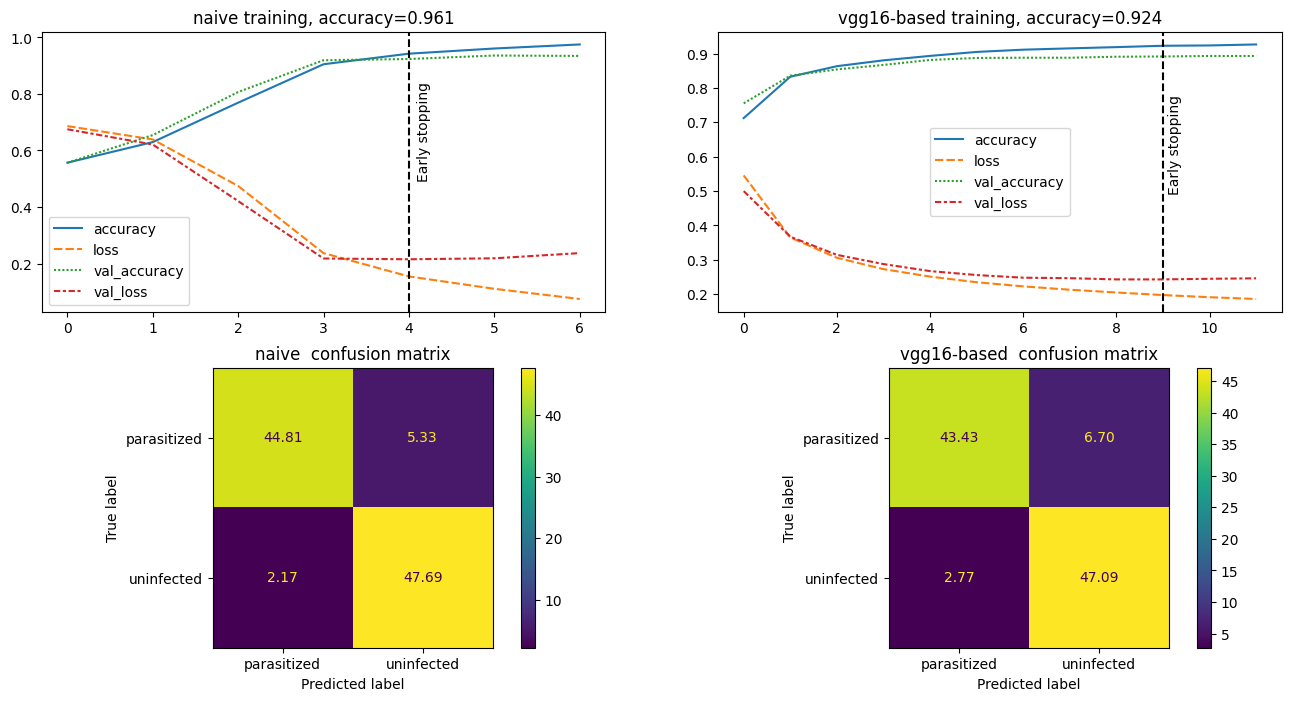

In [349]:
m1 = ModelEvaluator(
        name='naive',
        hidden_layers=[
            conv(32),
            conv(64),
            conv(128),
            Flatten(),
            dense(64)
        ]
    )
m2 = ModelEvaluator(
        name='vgg16-based',
        hidden_layers=[
            Conv2D(3, (3, 3), padding='same'),
            set_trainable(VGG16(weights='imagenet', include_top=False, input_shape=(121, 121, 3)), False),
            GlobalAveragePooling2D(),
            Dense(128, activation='relu')
        ]
    )

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
m1.plt_hst(ax[0,0])
m2.plt_hst(ax[0,1])
m1.plt_cm(ax[1,0])
m2.plt_cm(ax[1,1])


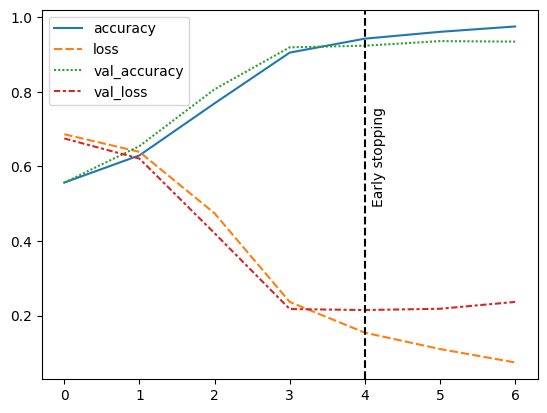

AttributeError: 'numpy.ndarray' object has no attribute 'figure'

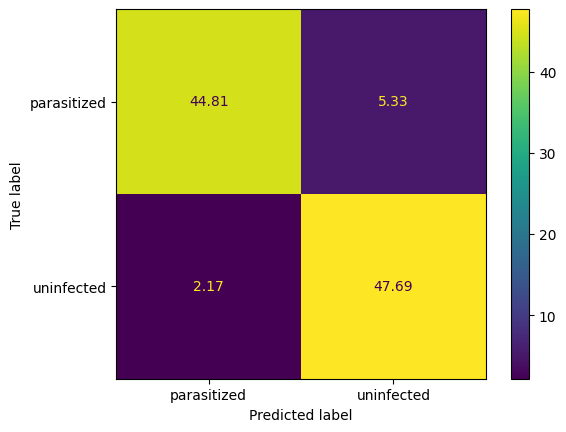

In [350]:
(
    ModelEvaluator(
        name='naive',
        hidden_layers=[
            conv(32),
            conv(64),
            conv(128),
            Flatten(),
            dense(64)
        ]
    )
        .plot_history()
        .plot_confusion_matrix());


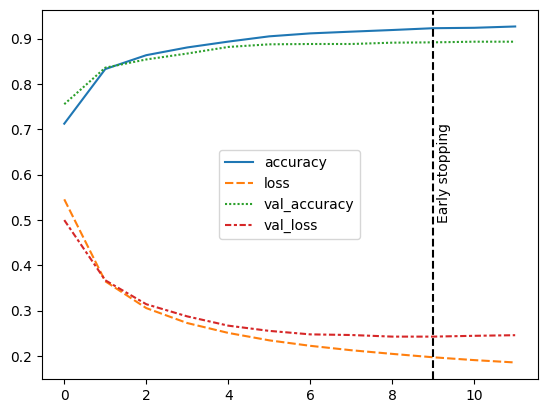

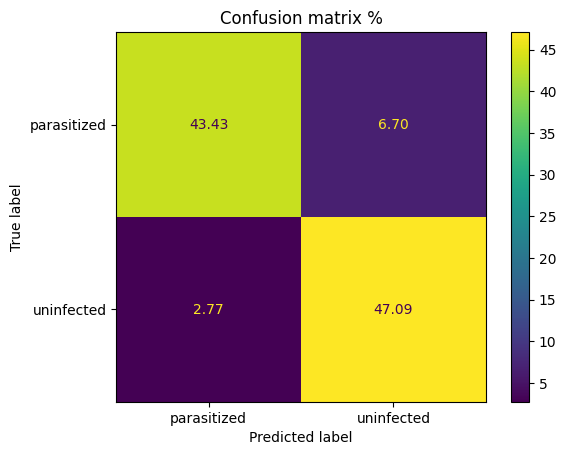

In [ ]:
( # 48 minuter
    ModelEvaluator(
        name='vgg16-based',
        hidden_layers=[
            Conv2D(3, (3, 3), padding='same'),
            set_trainable(VGG16(weights='imagenet', include_top=False, input_shape=(121, 121, 3)), False),
            GlobalAveragePooling2D(),
            Dense(128, activation='relu')
        ]
    )
    .plot_history() # 48 min
    .plot_confusion_matrix());
